# Closed transport budget
With the help of Ryan's [function](https://notebooksharing.space/view/6e69c44141e8b2b4815af808542a3e5e8c1a065077a07586447fae9a397bc414#displayOptions=)

In [1]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
import xmitgcm
import xgcm
from xhistogram.xarray import histogram
from fastjmd95 import jmd95numba
import fastjmd95
import json

In [2]:
#bringing in uploaded ds

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

def open_ds(filename):
    path = "gs://pangeo-tmp/stb2145/models/SODA/"
    return xr.open_dataset((path + filename), engine="zarr", backend_kwargs={"storage_options": {"token": token}})

transport = open_ds('transport_wg.zarr')
#cells = open_ds('cells_wg.zarr')
#surf = open_ds('surf_terms.zarr')
#totend = open_ds('totend.zarr')

In [3]:
path = 'pangeo-tmp/stb2145/models/SODA/'

transport = xr.open_zarr(gcfs_w_token.get_mapper(path + 'transport_wg.zarr'))

## <font color='Green'>\begin{equation*} \Psi_{vel} = \vec{\textbf{u}} \cdot \nabla \sigma_2 \end{equation*}</font>

In [4]:
t = 20

In [5]:
#truncating xt,yt so that xu,yu encompass the entire T cell region
transport_trunc = transport.isel(time=t)#, xt_ocean=slice(1, -1), yt_ocean=slice(None, -1))

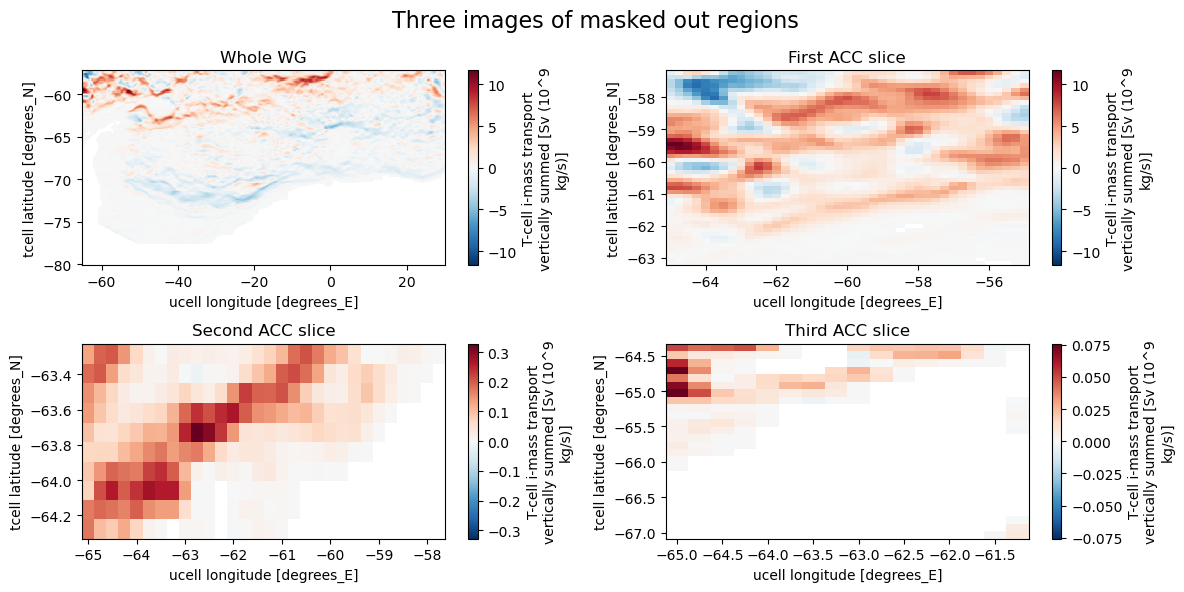

In [9]:
fig, ax = plt.subplots(2,2, figsize=(12,6))

transport_trunc.tx_int.plot(ax=ax[0,0])
ax[0,0].set_title('Whole WG')
transport_trunc.tx_int[159:None, None:41].plot(ax=ax[0,1])
ax[0,1].set_title('First ACC slice')
transport_trunc.tx_int[149:159, None:30].plot(ax=ax[1,0])
ax[1,0].set_title('Second ACC slice')
transport_trunc.tx_int[123:149, None:16].plot(ax=ax[1,1])
ax[1,1].set_title('Third ACC slice')

plt.suptitle('Three images of masked out regions', fontsize=16)
plt.tight_layout();

In [19]:
# Given upper right / lower left cell coordinates, construct the tx_trans and ty_trans sections that bound it

def box_budget(ds0, left_i, right_i, lower_j, upper_j,):
    """Function to compute box budget given any set of boundaries"""

    ty_upper = ds0.ty_int.isel(xt_ocean=slice(left_i, right_i+1), yu_ocean=upper_j)
    ty_lower = ds0.ty_int.isel(xt_ocean=slice(left_i, right_i+1), yu_ocean=lower_j-1)
    tx_right = ds0.tx_int.isel(xu_ocean=right_i, yt_ocean=slice(lower_j, upper_j+1))
    tx_left = ds0.tx_int.isel(xu_ocean=left_i-1, yt_ocean=slice(lower_j, upper_j+1))
    
    return -ty_upper.sum().values + ty_lower.sum().values - tx_right.sum().values + tx_left.sum().values

In [23]:
box1 = box_budget(transport_trunc,  41, 380, 159, 207)
box2 = box_budget(transport_trunc, 30, 380, 149, 159)
box3 = box_budget(transport_trunc, 16, 380, 123, 149)
box4 = box_budget(transport_trunc, 1, 380, 1, 123)

residual = box1 + box2 + box3 + box4
residual

-0.0086315945

### Trying universal box_budget module on entire timeseries

In [69]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [70]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.e3470bdc23864a7aa7d53105f208e693/status,


In [1]:
client.close()
cluster.close()

NameError: name 'client' is not defined

In [12]:
#load in autoreload so you don't have to restart kernel everytime you want to run bb function
%load_ext autoreload

#Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import bb

In [18]:
box1 = bb.box_budget(transport.tx_int, transport.ty_int,  41, 380, 159, 207)
box2 = bb.box_budget(transport.tx_int, transport.ty_int, 30, 380, 149, 159)
box3 = bb.box_budget(transport.tx_int, transport.ty_int, 16, 380, 123, 149)
box4 = bb.box_budget(transport.tx_int, transport.ty_int, 1, 380, 1, 123)

residual = box1 + box2 + box3 + box4

In [19]:
residual.mean('time').values

array(-0.10021526, dtype=float32)

### Close budget w universal module on entire `trans` timeseries, using optional `kwargs`

In [29]:
import bb

`trans` is 50x larger than `int`

In [65]:
#right
box1_r = bb.box_budget(transport.tx_trans, transport.ty_trans,  41, 380, 159, 207, bs='right')
box2_r = bb.box_budget(transport.tx_trans, transport.ty_trans, 30, 380, 149, 159, bs='right')
box3_r = bb.box_budget(transport.tx_trans, transport.ty_trans, 16, 380, 123, 149, bs='right')
box4_r = bb.box_budget(transport.tx_trans, transport.ty_trans, 1, 380, 1, 123, bs='right')

u_transport_right = (box1_r.sum(('yt_ocean', 'st_ocean')) + box2_r.sum(('yt_ocean', 'st_ocean')) + 
                     box3_r.sum(('yt_ocean', 'st_ocean')) + box4_r.sum(('yt_ocean', 'st_ocean')))

In [66]:
#left
box1_l = bb.box_budget(transport.tx_trans, transport.ty_trans,  41, 380, 159, 207, bs='left')
box2_l = bb.box_budget(transport.tx_trans, transport.ty_trans, 30, 380, 149, 159, bs='left')
box3_l = bb.box_budget(transport.tx_trans, transport.ty_trans, 16, 380, 123, 149, bs='left')
box4_l = bb.box_budget(transport.tx_trans, transport.ty_trans, 1, 380, 1, 123, bs='left')

u_transport_left = (box1_l.fillna(0.).sum(('yt_ocean', 'st_ocean')) + box2_l.fillna(0.).sum(('yt_ocean', 'st_ocean')) + 
                    box3_l.fillna(0.).sum(('yt_ocean', 'st_ocean')) + box4_l.fillna(0.).sum(('yt_ocean', 'st_ocean')))

In [67]:
#upper
box1_u = bb.box_budget(transport.tx_trans, transport.ty_trans,  41, 380, 159, 207, bs='upper')
box2_u = bb.box_budget(transport.tx_trans, transport.ty_trans, 30, 380, 149, 159, bs='upper')
box3_u = bb.box_budget(transport.tx_trans, transport.ty_trans, 16, 380, 123, 149, bs='upper')
box4_u = bb.box_budget(transport.tx_trans, transport.ty_trans, 1, 380, 1, 123, bs='upper')

v_transport_upper = (box1_u.fillna(0.).sum(('xt_ocean', 'st_ocean')) + box2_u.fillna(0.).sum(('xt_ocean', 'st_ocean')) + 
                     box3_u.fillna(0.).sum(('xt_ocean', 'st_ocean')) + box4_u.fillna(0.).sum(('xt_ocean', 'st_ocean')))

In [68]:
#lower
box1_lo = bb.box_budget(transport.tx_trans, transport.ty_trans,  41, 380, 159, 207, bs='lower')
box2_lo = bb.box_budget(transport.tx_trans, transport.ty_trans, 30, 380, 149, 159, bs='lower')
box3_lo = bb.box_budget(transport.tx_trans, transport.ty_trans, 16, 380, 123, 149, bs='lower')
box4_lo = bb.box_budget(transport.tx_trans, transport.ty_trans, 1, 380, 1, 123, bs='lower')

v_transport_lower = (box1_lo.fillna(0.).sum(('xt_ocean', 'st_ocean')) + box2_lo.fillna(0.).sum(('xt_ocean', 'st_ocean')) + 
                     box3_lo.fillna(0.).sum(('xt_ocean', 'st_ocean')) + box4_lo.fillna(0.).sum(('xt_ocean', 'st_ocean')))

In [81]:
u_transport_right.load()

<xarray.DataArray 'right' (time: 985)>
array([-9.21535206e+00, -6.45426273e+00,  8.89617920e+00,  3.16493225e+00,
        7.30206823e+00,  3.87625599e+00, -2.35693092e+01, -2.20525742e+01,
       -6.76553726e+00, -1.83796043e+01, -1.11163950e+01, -2.07088585e+01,
       -2.33605957e+01, -4.47102318e+01, -4.35750427e+01, -4.31375504e+01,
       -2.88929806e+01, -2.92711506e+01, -2.73969154e+01, -2.04088688e+01,
       -3.15495415e+01, -3.35478897e+01, -2.52367363e+01, -2.02329292e+01,
       -8.53377342e+00, -2.69949760e+01, -1.73150692e+01, -1.52501297e+01,
       -3.35849571e+01, -2.94463959e+01, -5.01598549e+01, -5.26951256e+01,
       -4.73119392e+01, -5.13604813e+01, -4.34266510e+01, -4.54167862e+01,
       -2.49123478e+01, -8.37513828e+00, -8.95122910e+00, -8.24137878e+00,
       -2.26643143e+01, -1.44402752e+01, -1.62889385e+00,  3.08646202e+00,
        3.82261047e+01,  1.96810417e+01,  1.03070927e+00, -2.91046715e+01,
       -1.92485542e+01, -4.52955399e+01, -5.28581200e+01, -4.83646088e+01,
       -6.06869545e+01, -6.66843643e+01, -6.91550446e+01, -4.53774757e+01,
       -6.44347992e+01, -4.44043007e+01, -4.84544640e+01, -3.94067535e+01,
       -4.18166695e+01, -3.18278408e+01, -1.03938885e+01, -5.52040386e+00,
        1.17270880e+01,  3.06090546e+01,  1.07265663e+01,  2.70451164e+00,
       -1.12232876e+00, -1.29511719e+01, -1.17434816e+01,  6.86579227e-01,
        1.38519993e+01,  9.99743080e+00, -4.82966518e+00, -1.81876040e+00,
       -1.76502037e+01, -4.60136843e+00, -9.26493263e+00, -7.62618017e+00,
...
        1.50006590e+01,  5.08380222e+00,  3.08954430e+00, -1.07772522e+01,
       -3.26099663e+01, -1.41509895e+01, -4.16221285e+00, -4.18087435e+00,
       -8.33186722e+00, -2.10795689e+00,  1.31238651e+00, -4.78243828e-01,
       -1.85683041e+01, -1.34475021e+01, -2.54408016e+01, -5.80071869e+01,
       -2.22915878e+01, -3.38785172e-01, -3.03781128e+00, -2.70080643e+01,
       -3.60738983e+01, -3.87036972e+01, -4.10719948e+01, -2.75090370e+01,
       -2.41007843e+01, -1.63401146e+01, -2.76894302e+01, -5.74030228e+01,
       -4.44278259e+01, -6.38881397e+00,  1.45418434e+01, -1.28091106e+01,
        2.96909332e-01,  2.09732742e+01,  3.91027832e+01,  3.54635582e+01,
        2.60309143e+01,  1.65951729e+00, -1.28397732e+01, -3.70637474e+01,
       -4.77488632e+01, -4.67246399e+01, -5.52678490e+01, -3.94382744e+01,
       -1.98386898e+01, -1.20694046e+01, -1.04103642e+01, -2.61325932e+00,
       -1.60517216e+01, -1.34182596e+01, -9.87710571e+00, -8.90659904e+00,
       -2.12786732e+01, -2.26617203e+01, -5.99210167e+00,  1.07492886e+01,
       -4.20898438e+00, -6.15760422e+00, -1.49690371e+01,  3.83088875e+00,
       -3.75267258e+01, -4.28677444e+01, -2.95053043e+01, -2.08154297e+01,
       -5.61272049e+00,  8.46146679e+00,  3.99437332e+01,  5.54522400e+01,
        2.08438797e+01,  2.58044968e+01,  2.74598885e+01,  1.53467846e+00,
        7.26478767e+00, -1.05066404e+01, -1.58766365e+01, -3.10700512e+01,
       -2.29262772e+01], dtype=float32)
Coordinates:
  * time      (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
    xu_ocean  float64 30.0

In [80]:
u_transport_left.load()

<xarray.DataArray 'left' (time: 985)>
array([ 56.59742 ,  54.385036,  63.776394,  55.828518,  55.637615,
        60.88018 ,  56.2802  ,  48.678234,  45.637054,  49.035564,
        57.922077,  54.261497,  56.14943 ,  74.79967 ,  68.30617 ,
        58.023476,  62.708282,  57.371185,  55.42924 ,  58.00632 ,
        58.819645,  70.32111 ,  77.43394 ,  73.877975,  79.879684,
        78.036934,  83.593605,  81.57707 ,  78.06775 ,  81.13709 ,
        74.19436 ,  68.789536,  73.207596,  66.76365 ,  68.20958 ,
        47.911865,  46.028595,  77.29915 , 103.22938 ,  42.045887,
        52.431652,  59.10224 ,  64.557434,  53.748928,  49.088768,
        47.540592,  44.610107,  34.327126,  41.666428,  46.952854,
        45.50364 ,  60.075287,  62.832256,  53.79096 ,  46.16596 ,
        46.6009  ,  54.7847  ,  62.506237,  61.55824 ,  65.26425 ,
        69.841965,  68.90276 ,  60.994892,  51.7383  ,  54.91586 ,
        51.61054 ,  45.743607,  47.57829 ,  38.62793 ,  40.12489 ,
        48.093914,  62.394405,  72.44606 ,  67.10869 ,  63.763092,
        63.585472,  67.20873 ,  60.81914 ,  55.617996,  49.066242,
        56.745075,  54.98874 ,  60.941845,  55.40618 ,  59.88192 ,
        61.206066,  67.53218 ,  53.28739 ,  59.551826,  74.296715,
        66.93809 ,  70.64368 ,  75.73555 ,  62.004276,  57.419735,
        56.851402,  47.376152,  48.47649 ,  57.38348 ,  73.66919 ,
...
        44.71437 ,  47.224785,  47.417072,  48.098816,  45.539436,
        64.67089 ,  57.14049 ,  78.11133 ,  59.32921 ,  58.969406,
        55.350887,  55.643806,  44.958683,  46.959763,  46.163425,
        39.78574 ,  50.57955 ,  56.51649 ,  64.33395 ,  66.83304 ,
        50.614025,  40.06517 ,  54.42394 ,  59.194283,  53.500694,
        47.498653,  46.753048,  49.178524,  54.22761 ,  53.757935,
        63.933643,  56.85147 ,  49.51988 ,  48.119946,  48.453938,
        52.611427,  69.99147 ,  73.96942 ,  79.67879 ,  72.87311 ,
        67.498604,  75.566216,  71.2326  ,  66.75099 ,  59.33922 ,
        55.1652  ,  46.724167,  49.31625 ,  50.240635,  52.50375 ,
        56.833294,  55.37846 ,  53.492493,  58.659317,  55.827896,
        52.058983,  58.965458,  49.77002 ,  31.69425 ,  56.952995,
        61.699512,  68.21931 ,  69.071304,  74.04136 ,  58.534767,
        37.247818,  53.571373,  66.97692 ,  51.81875 ,  40.719845,
        65.49442 ,  59.843735,  43.698986,  45.517048,  29.540564,
        36.351765,  45.675888,  45.332306,  46.767918,  46.360897,
        49.404797,  24.240507,  43.142258,  36.91114 ,  42.207405,
        40.357574,  51.114227,  36.9627  ,  39.844654,  34.60669 ,
        33.533916,  39.625732,  50.095   ,  51.36335 ,  49.17674 ],
      dtype=float32)
Coordinates:
  * time     (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00

In [82]:
v_transport_lower.load()

<xarray.DataArray 'lower' (time: 985)>
array([ 1.83730450e+01,  3.30016670e+01,  3.45539780e+01,  4.47593040e+01,
        2.37423630e+01,  2.22793312e+01,  4.35193291e+01,  3.34535904e+01,
        3.18474770e+01,  4.53373070e+01,  4.25175514e+01,  5.59803467e+01,
        5.68081551e+01,  7.03219070e+01,  7.64306259e+01,  6.65399094e+01,
        6.06411781e+01,  6.03763199e+01,  6.64541473e+01,  3.50691719e+01,
        3.46049232e+01,  4.51230087e+01,  4.85092773e+01,  5.06510010e+01,
        5.09777412e+01,  7.92360153e+01,  5.99826279e+01,  5.11296120e+01,
        5.41658058e+01,  3.19440269e+01,  2.87756195e+01,  2.96420460e+01,
        4.01817741e+01,  4.75197868e+01,  2.93877640e+01,  3.52241287e+01,
        2.81302414e+01,  1.84100647e+01,  4.61267929e+01,  2.35997810e+01,
        4.29960327e+01,  4.93417206e+01,  4.27424049e+01,  4.92779007e+01,
        5.03826561e+01,  4.75479851e+01,  6.61438141e+01,  9.54650574e+01,
        8.44879532e+01,  7.07718277e+01,  5.59925461e+01,  5.74074326e+01,
        8.13976059e+01,  1.03602234e+02,  1.18167969e+02,  1.00636154e+02,
        1.34797226e+02,  9.43169403e+01,  7.29903336e+01,  3.02311020e+01,
        6.49398193e+01,  8.95591507e+01,  6.88134995e+01,  6.76437531e+01,
        4.77361488e+01,  3.70597954e+01,  3.40449066e+01,  4.15529022e+01,
        3.86408997e+01,  5.20931015e+01,  5.36958771e+01,  4.21448441e+01,
        3.11724777e+01,  2.27361298e+01,  3.91189995e+01,  3.45944214e+01,
        6.05786324e+01,  3.96972580e+01,  4.18039169e+01,  3.38234329e+01,
...
        3.92495384e+01,  2.60453606e+01,  2.35350990e+01,  3.02760124e+01,
        4.97477341e+01,  2.67078686e+01,  2.85501804e+01,  2.83435936e+01,
        3.39964371e+01,  2.47105408e+01,  3.49040985e+01,  3.64339600e+01,
        4.85622292e+01,  4.24126625e+01,  8.56609192e+01,  1.34157867e+02,
        1.10812378e+02,  8.35788651e+01,  8.00217056e+01,  9.79777145e+01,
        7.34032516e+01,  8.58767395e+01,  9.35640564e+01,  5.26395073e+01,
        5.86892624e+01,  7.10716476e+01,  7.77937012e+01,  9.50481567e+01,
        8.54440994e+01,  5.87475433e+01,  3.33666801e+01,  5.56309013e+01,
        4.38363495e+01,  5.51008835e+01,  4.15421600e+01,  3.58138199e+01,
        3.16901054e+01,  5.41639404e+01,  4.38157349e+01,  5.15707321e+01,
        6.85868759e+01,  5.73631630e+01,  5.21486168e+01,  3.73175850e+01,
        3.46986465e+01,  4.26330948e+01,  5.44090462e+01,  4.62814140e+01,
        4.15013885e+01,  5.25091515e+01,  2.63070602e+01,  2.86238880e+01,
        6.34646606e+01,  8.33793793e+01,  8.18069229e+01,  7.78137207e+01,
        9.78773193e+01,  6.77842484e+01,  6.21499367e+01,  5.20013390e+01,
        5.25181618e+01,  5.54083328e+01,  6.10825424e+01,  6.80373077e+01,
        5.04456253e+01,  8.40378799e+01,  6.50184097e+01,  3.99430885e+01,
        5.57305908e+01,  4.28237991e+01,  4.64920120e+01,  7.01578293e+01,
        5.20541916e+01,  7.33834457e+01,  5.58836937e+01,  6.70200272e+01,
        6.43861389e+01], dtype=float32)
Coordinates:
  * time     (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00

In [ ]:
v_transport_upper.load()

In [ ]:
#going off of sign convention from bb.py module
residual = - u_transport_right + u_transport_left - v_transport_upper + v_transport_lower
residual.mean('time').values